In [6]:
%matplotlib inline

import os
import sys

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../..')

%load_ext autoreload
%autoreload 2

from video_processing.yolov11.data.utils import imread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from __future__ import annotations
from typing import Any
import numbers

from video_processing.yolov11.instance.instance import Instances

class LetterBox:
    """
    Resize image and padding for detection, instance segmentation, pose.

    This class resizes and pads images to a specified shape while preserving aspect ratio. It also updates
    corresponding labels and bounding boxes
    """
    def __init__(self, new_shape:tuple[int,int]=(640,640), auto:bool=False, scale_fill:bool=False, scaleup:bool=False,
        center:bool=True, stride=32, padding_value:int=114, interpolation=cv2.INTER_LINEAR):
        """
        Initialize LetterBox object for resizing and padding images
        This class is designed to resize and pad images for object detection, instance segmentation, and pose 
        estimation tasks. It supports various resizing modes including auto-sizing, scale-fill, and letterboxing.
        Args:
            new_shape(tuple[int, int]): Target size (height, width) for resized image
            auto (bool): If True, use minimum rectangle to resize. If False, use new_shape directly
            scale_fill (bool): If True, stretch the image to new_shape without padding
            scaleup (bool): If True, allow scaling up. If False, only scale down
            center (bool): If True, center the placed image. If False, place image in top-left corner.
            stride (int): Stride of the model (e.g., 32 for yolov11)
            padding_value (int): Value for padding the image. Default is 114
            interpolation (int): Interpolation method for resizing. Default is cv2.INTER_LINEAR.
        Examples:
            >>> letterbox=LetterBox(new_shape=(640,640), auto=False, scale_fill=False, scaleup=True, stride=32)
            >>> resized_img=letterbox(original_img)
        """
        self.new_shape=new_shape
        self.auto=auto
        self.scale_fill=scale_fill
        self.scaleup=scaleup
        self.stride=stride
        self.center=center # put the image in the middle or top-left
        self.padding_value=padding_value
        self.interpolation=interpolation
    
    def __call__(self,image:np.ndaary=None,labels:dict[str, Any]=None)->np.ndarray | dict[str, Any]:
        """
        Resize and pad an image for object detection, instance segmentation, or pose estimation tasks.

        This method applies letterboxing to the input image, which involves resizing the image while 
        maintaining its aspect ratio and adding padding to fit the new shape. It also updates any associated 
        labels accordingly.

        Args:
            image (np.ndarray | None): The input image as a numpy array. If None, the image is taken from `labels`
            labels (dict[str, Any] | None): A dict containing imag edata and labels or None
        Returns:
            (np.ndarray | dict[str, Any]): If `image` is provided, return the resized and padded image; otherwise,
                return an updated dict with the resized and padded image and update labels
        Examples:
            >>> letterbox=LetterBox(new_shape=(640,640))
            >>> result=letterbox(labels={'img':np.zeros((480,640,3)), 'instances':Instances(...)})
            >>> resized_img=result['img']
            >>> updated_instances=result['instances']
        """
        if labels is None: labels=dict()
        img=labels.get('img') if image is None else image
        shape=img.shape[:2] # H, W
        new_shape=labels.pop('rect_shape', self.new_shape) # if rect_shape not in `labels`, return self.new_shape
        if isinstance(new_shape, numbers.Number): new_shape=(new_shape, new_shape)

        # scale ratio: new/old
        r=min(n/o for n,o in zip(new_shape, shape))
        # only scale down, do not scale up for better mAP
        if not self.scaleup: r=min(r, 1.)

        ratio=r,r
        # computing padding
        new_unpad=[int(round(s*r)) for s in shape] # H, W
        dh,dw=(s-u for s, u in zip(new_shape, new_unpad)) 
        if self.auto: # minimum rectangle
            dh,dw=np.mod(dh, self.stride), np.mod(dw, self.stride)
        elif self.scale_fill: # stretch
            dh=dw=0.
            new_unpad=new_shape # H W
            ratio=(n/o for n, o in zip(new_shape[::-1], shape[::-1])) # width, height ratio

        if self.center: # divide padding into 2 sides
            dw/=2; dh/=2
        if shape!=new_unpad: # resize
            img=cv2.resize(img, new_unpad[::-1], interpolation=self.interpolation) # input size to CV must be width, height
            if img.ndim==2: img=img[...,None]

        top, bottom=int(round(dh-0.1)) if self.center else 0, int(round(dh+0.1))
        left, right=int(round(dw-0.1)) if self.center else 0, int(round(dw+0.1))
        h, w, c=img.shape
        if c==3: img=cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(self.padding_value,)*3)
        else: # multispectral 
            pad_img=np.full((h+top+bottom, w+left+right, c), fill_value=self.padding_value, dtype=img.dtype)
            pad_img=img[top:(top+h), left:(left+w)]
            img=pad_img

        if labels.get('ratio_pad'): labels['ratio_pad']=(labels['ratio_pad'], (left, top)) # for evaluation
        if len(labels):
            labels=self._update_labels(labels, ratio, left, top)
            labels['img']=img
            labels['resized_shape']=new_shape
            return labels
        return img

    @staticmethod
    def _update_labels(labels:dict[str, Any], ratio:tuple[float, float], padw:float, padh:float)->dict[str, Any]:
        """
        Update labels after applying letterboxing to an image

        This method modifies the bounding box coordinates of instances in the labels to account for resizing and padding applied 
        during letterboxing.
        Args:
            labels (dict[str, Any]): A dict containing image labels and instances
            ratio (tuple[float, float]): Scaling ratios (width, height) applied to the image
            padw (float): Padding width added to the image
            padh (float): Padding height added to the image
        Returns:
            (dict[str, Any]): Update labels dict with modified instance coordinates
        Examples:
            >>> letterbox=LetterBox(new_shape=(640,640))
            >>> labels={'instances':Instances(...)}
            >>> ratio=(.5,.5)
            >>> padw,padh=10,20
            >>> updated_labels=letterbox._update_labels(labels, ratio, padw, padh)
        """
        labels['instances'].convert_bbox(format='xyxy')
        labels['instances'].denormalize(*labels['img'].shape[:2][::-1])
        labels['instances'].scale(*ratio)
        labels['instances'].add_padding(padw, padh)
        return labels

In [12]:
labels={'img':np.zeros((1,1
                        ,3))}
new_shape=(50,50)
labels.pop('rect_shape', new_shape)
labels

{'img': array([[[0., 0., 0.]]])}

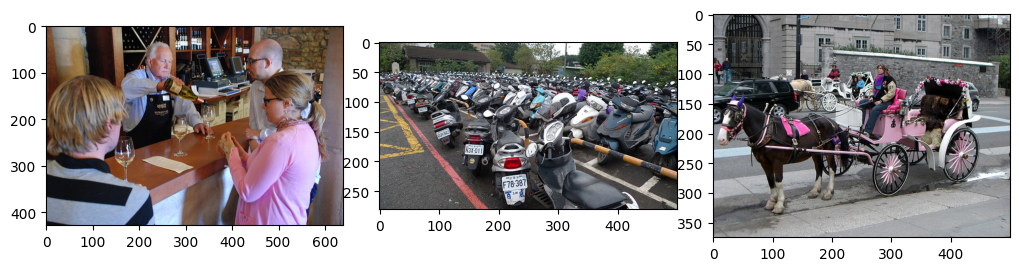

In [13]:
data_dirpath='D:/data/coco/coco/images/test2017'
image_files=['000000000069.jpg', '000000000774.jpg', '000000502391.jpg']
images=[imread(os.path.join(data_dirpath, file)) for file in image_files]
_, ax=plt.subplots(1,3,figsize=(10,3))
for i, im in enumerate(images): ax[i].imshow(im[...,::-1]) # BGR to RGB
plt.tight_layout(pad=0, w_pad=0, h_pad=0)

[`pre_transform`](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/engine/predictor.py#L152) in `predictor.py`

same_shape  False
imgs_  [(640, 640, 3), (640, 640, 3), (640, 640, 3)]


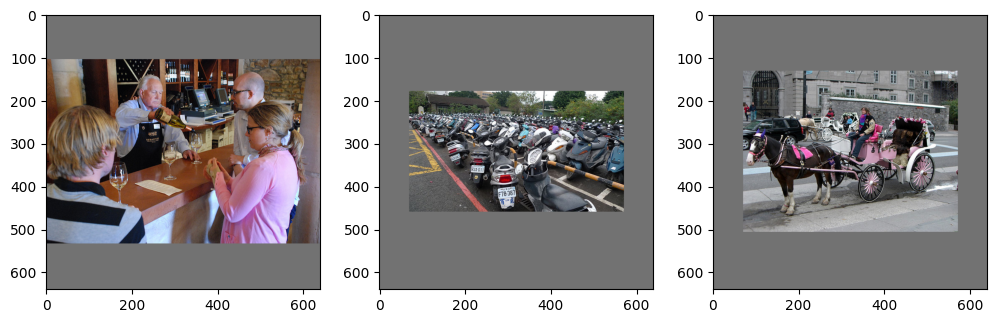

In [20]:
same_shape=len({x.shape for x in images})==1
print('same_shape ', same_shape)
letterbox=LetterBox((640,640), auto=same_shape, stride=32)
imgs_=[letterbox(image=x) for x in images]
print('imgs_ ', [i.shape for i in imgs_])
_, ax=plt.subplots(1,3,figsize=(10,3))
for i, im in enumerate(imgs_): ax[i].imshow(im[...,::-1]) # BGR to RGB
plt.tight_layout(pad=0, w_pad=0, h_pad=0)